In [1]:
!pip install yfinance

In [21]:
# In[Imports]

import yfinance as yf
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [23]:
# In[Parameters]

#define the ticker symbol
ticker_symbols = ['TSLA','GOOG','AMZN','AAPL']

#number of days
window_size = 365

#split ratio points of dataset
train_stop = 0.7
test_start = 0.9

#number of training cycles/iterations
epoch = 15

#early staopping trigger
wait = 20

#training cycles before weights are updated
batch = 1

#how many epochs between checking validation data
val_freq = 1


In [24]:
# In[Create DataFrame]

df_dict = {}
for symbol in ticker_symbols:
    #get data on each ticker
    ticker_data = yf.Ticker(symbol)
    
    #get the historical prices for each ticker
    df_dict[symbol] = ticker_data.history(period='1d', start='2010-1-1', end='2021-1-1')

#make dataframe
data = pd.concat(df_dict, axis = 1)

#replace nans with zeros
data = data.fillna(0)


In [25]:
# In[Create Targets]

scaled_target = {}
for i in range(data.shape[0] - 1):
    closes = []
    for ticker in ticker_symbols:
        closes.append(data[(ticker, 'Close')][i + 1])
    scaled_target[data.index[i]] = closes

#create dataframe of targets
scaled_target = pd.DataFrame.from_dict(scaled_target ,orient = 'index', columns = ticker_symbols)

#drop last day, since we don't know the closing for tomorrow
data = data[: -1]


In [26]:
# In[Normalize Data]

n = len(data)

scaler = MinMaxScaler()
scaler.fit(data[0 : int(n * train_stop)])
scaled_data = scaler.transform(data)


In [27]:
# In[Create Windows]

x = []
y = []

#goes from end of first window to end of data
for i in range(window_size, scaled_data.shape[0]):
    x.append(scaled_data[i - window_size : i])
    y.append(scaled_target[i : i + 1])
    
x = np.array(x)
y = np.array(y)


In [28]:
# In[Split Data]

#same names of labels
#data_column_indices = {name : i for i, name in enumerate(scaled_data.columns)}
#target_column_indices = {name : i for i, name in enumerate(scaled_target.columns)}

n = x.shape[0]

x_train = x[0 : int(n * train_stop)]
x_val = x[int(n * train_stop) : int(n * test_start)]
x_test = x[int(n * test_start) :]

y_train = y[0 : int(n * train_stop)]
y_val = y[int(n * train_stop) : int(n * test_start)]
y_test = y[int(n * test_start) :]

num_features = scaled_data.shape[1]


In [29]:
# In[Create Model]

model = Sequential([
                    Bidirectional(LSTM(units = 32, return_sequences = True), input_shape = (x_train.shape[1], x_train.shape[2])),
                    Dropout(0.2),
                          
                    Bidirectional(LSTM(units = 32, return_sequences = True)),
                    Dropout(0.2),
                    
                    Bidirectional(LSTM(units = 32, return_sequences = True)),
                    Dropout(0.2),
                          
                    Bidirectional(LSTM(units = 32, return_sequences = False)),
                    Dropout(0.2),
                          
                    Dense(units = len(ticker_symbols), activation='linear')
                   ])

model.compile(
              #loss = 'mean_squared_error',
              loss = 'mse',
              optimizer = RMSprop(learning_rate = 1e-4),
              metrics=['mae']
             )

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_14 (Bidirectio (None, 365, 64)           15616     
_________________________________________________________________
dropout_14 (Dropout)         (None, 365, 64)           0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 365, 64)           24832     
_________________________________________________________________
dropout_15 (Dropout)         (None, 365, 64)           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 365, 64)           24832     
_________________________________________________________________
dropout_16 (Dropout)         (None, 365, 64)           0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 64)               

In [30]:
# In[Train Model]

history = model.fit(
                    x = x_train,
                    y = y_train,
                    epochs = epoch,
                    batch_size = batch,
                    shuffle = False,
                    validation_data = (x_val, y_val),
                    validation_freq = val_freq,
                    callbacks = [EarlyStopping(patience = wait)]
                   )


Epoch 1/15
1682/1682 [==============================] - 165s 94ms/step - loss: 70496.3995 - mae: 178.7359 - val_loss: 1086984.8750 - val_mae: 741.7569
Epoch 2/15
1682/1682 [==============================] - 158s 94ms/step - loss: 66623.5313 - mae: 169.4909 - val_loss: 1072813.1250 - val_mae: 733.2852
Epoch 3/15
1682/1682 [==============================] - 156s 92ms/step - loss: 63447.7607 - mae: 165.0577 - val_loss: 1058892.2500 - val_mae: 726.4924
Epoch 4/15
1682/1682 [==============================] - 156s 93ms/step - loss: 60424.1911 - mae: 160.9727 - val_loss: 1045124.9375 - val_mae: 720.2078
Epoch 5/15
1682/1682 [==============================] - 156s 92ms/step - loss: 57492.7172 - mae: 156.7264 - val_loss: 1031483.5625 - val_mae: 714.2150
Epoch 6/15
1682/1682 [==============================] - 156s 93ms/step - loss: 54591.4016 - mae: 152.3049 - val_loss: 1017937.9375 - val_mae: 708.3699
Epoch 7/15
1682/1682 [==============================] - 155s 92ms/step - loss: 51932.4342 - ma

In [31]:
# In[Test Model]

model.evaluate(
               x = x_test,
               y = y_test
              )

y_pred = model.predict(x_test)


8/8 [==============================] - 2s 57ms/step - loss: 2201623.0000 - mae: 1048.4303


In [32]:
print(y_test.reshape(y_test.shape[0], y_test.shape[2]))

[[ 109.44000244 1484.40002441 1892.           78.34780121]
 [ 113.91200256 1485.94995117 1887.45996094   78.62746429]
 [ 114.44000244 1486.65002441 1884.57995605   79.00611877]
 [ 112.96399689 1466.70996094 1861.64001465   78.77843475]
 [ 111.60399628 1433.90002441 1828.33996582   76.46192932]
 [ 113.37999725 1452.56005859 1853.25         78.62499237]
 [ 116.19799805 1458.63000488 1858.           80.2707901 ]
 [ 128.16200256 1455.83996582 1870.68005371   80.15447235]
 [ 130.11399841 1434.22998047 2008.7199707    76.60051727]
 [ 156.         1485.93994141 2004.19995117   76.39015961]
 [ 177.41200256 1447.06994629 2049.66992188   78.91207886]
 [ 146.94000244 1448.22998047 2039.86999512   79.55554962]
 [ 149.79200745 1476.22998047 2050.22998047   80.48610687]
 [ 149.61399841 1479.22998047 2079.2800293    79.39208984]
 [ 154.2559967  1508.68005371 2133.90991211   79.76916504]
 [ 154.87600708 1508.79003906 2150.80004883   79.28788757]
 [ 153.45799255 1518.27001953 2160.           81.1707992

In [33]:
print(y_pred)

[[ 42.79236  152.82074  147.0053    25.307238]
 [ 42.79236  152.82074  147.0053    25.307238]
 [ 42.79236  152.82074  147.0053    25.307238]
 [ 42.79236  152.82074  147.0053    25.307238]
 [ 42.79236  152.82074  147.0053    25.307238]
 [ 42.792362 152.82076  147.00531   25.30724 ]
 [ 42.792362 152.82076  147.00531   25.30724 ]
 [ 42.792362 152.82076  147.00531   25.30724 ]
 [ 42.792362 152.82076  147.00531   25.30724 ]
 [ 42.792362 152.82074  147.00531   25.30724 ]
 [ 42.792362 152.82074  147.0053    25.307238]
 [ 42.79236  152.82074  147.0053    25.307238]
 [ 42.79236  152.82074  147.0053    25.307238]
 [ 42.79236  152.82074  147.0053    25.307238]
 [ 42.792355 152.82072  147.0053    25.307236]
 [ 42.792355 152.82072  147.0053    25.307236]
 [ 42.792355 152.82072  147.0053    25.307234]
 [ 42.792355 152.82072  147.0053    25.307234]
 [ 42.792355 152.82072  147.00528   25.307232]
 [ 42.79235  152.82071  147.00528   25.307232]
 [ 42.79235  152.82071  147.00528   25.30723 ]
 [ 42.79235  

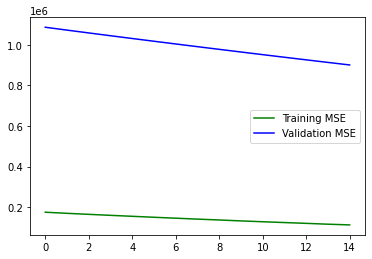

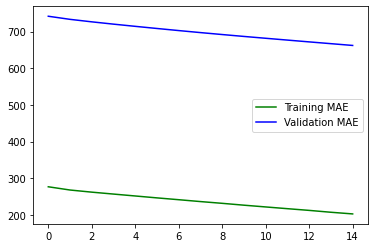

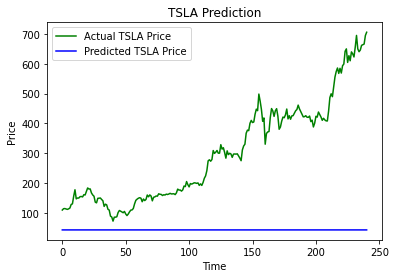

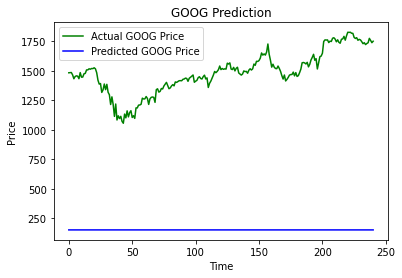

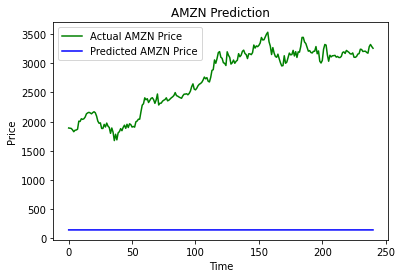

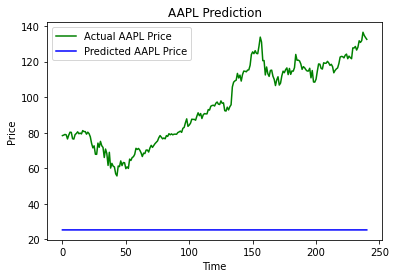

In [34]:
# In[Graph Results]

#plot loss
plt.plot(
         history.history['loss'],
         label = 'Training MSE',
         color = 'green',
         linestyle = 'solid'
        )

plt.plot(
         history.history['val_loss'],
         label = 'Validation MSE',
         color = 'blue',
         linestyle = 'solid'
        )

plt.legend()
plt.show()

#plot accuracy
plt.plot(

         history.history['mae'],
         label = 'Training MAE',
         color = 'green',
         linestyle = 'solid'
        )

plt.plot(
         history.history['val_mae'],
         label = 'Validation MAE',
         color = 'blue',
         linestyle = 'solid'
        )

plt.legend()
plt.show()


#plot stock predictions
y_test_2d = y_test.reshape(y_test.shape[0], y_test.shape[2])
y_pred = np.array(y_pred)

for i in range(len(ticker_symbols)):
    plt.plot(y_test_2d[:, i], color = 'green', label = 'Actual ' + ticker_symbols[i] + ' Price')
    plt.plot(y_pred[:, i], color = 'blue', label = 'Predicted ' + ticker_symbols[i] + ' Price')
    plt.title(ticker_symbols[i] + ' Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()